## import libraries

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MCS PyData tools
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_

# VISUALIZATION TOOLS
import matplotlib.pyplot as plt
%matplotlib inline

# SUPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

# autoreload modules
%load_ext autoreload
%autoreload 2

## import file

In [3]:
base_directory = r'C:\Users\Lenovo' # adjust this to your local environment
file_path = os.path.join(base_directory, 'MultiUnitData.h5')

In [4]:
file = McsPy.McsData.RawData(file_path)
electrode_stream = file.recordings[0].analog_streams[0];

Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (12, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (12,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (8, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (8,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


## Visualization


In [52]:
def plot_analog_stream_channel(analog_stream, channel_idx, from_in_s=0, to_in_s=None, show=True):
  
    # extract basic information
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude
   
    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(analog_stream.channel_data.shape[1], int(to_in_s * sampling_frequency))
        
    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(channel_id, from_idx, to_idx)

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second
    
    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV

    # construct the plot
    plt.figure(figsize=(20,6))
    plt.plot(time_in_sec, signal_in_uV)
    plt.xlabel('Time (%s)' % ureg.s)
    plt.ylabel('Voltage (%s)' % ureg.uV)
    plt.title('Channel %s' % channel_info.info['Label'])
    if show:
        plt.show()

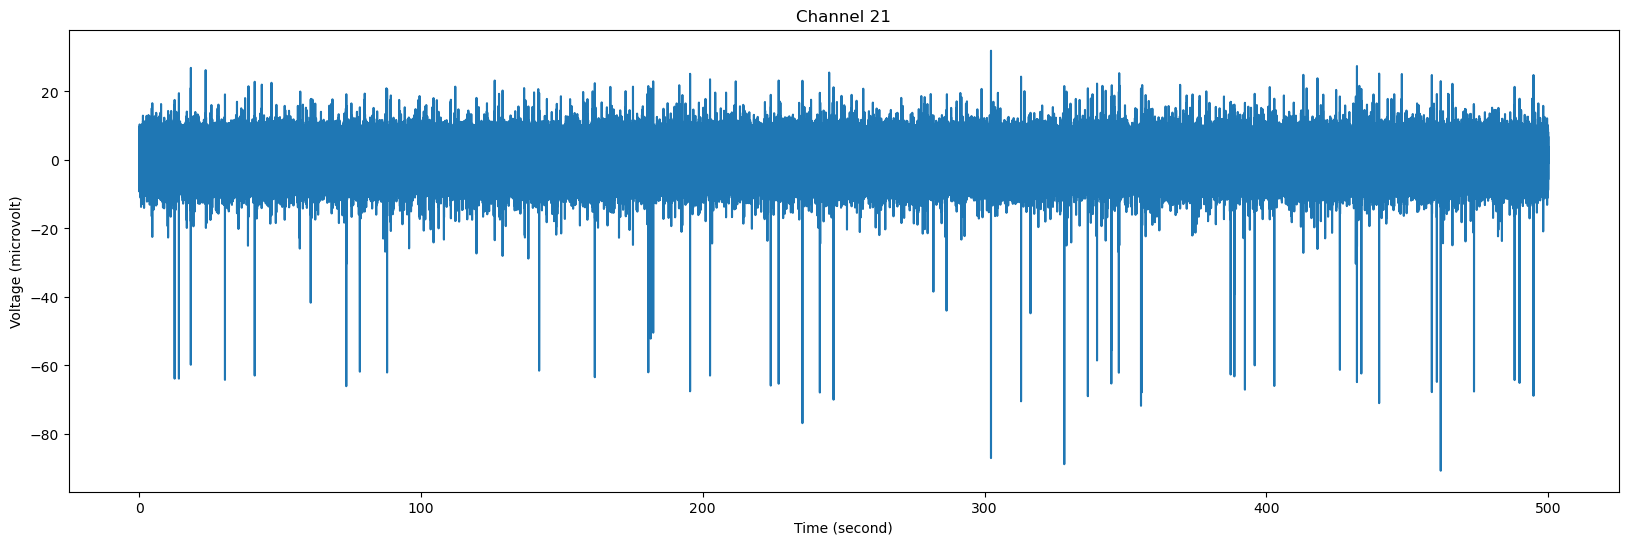

In [53]:
plot_analog_stream_channel(electrode_stream, 0, from_in_s=0, to_in_s=500)

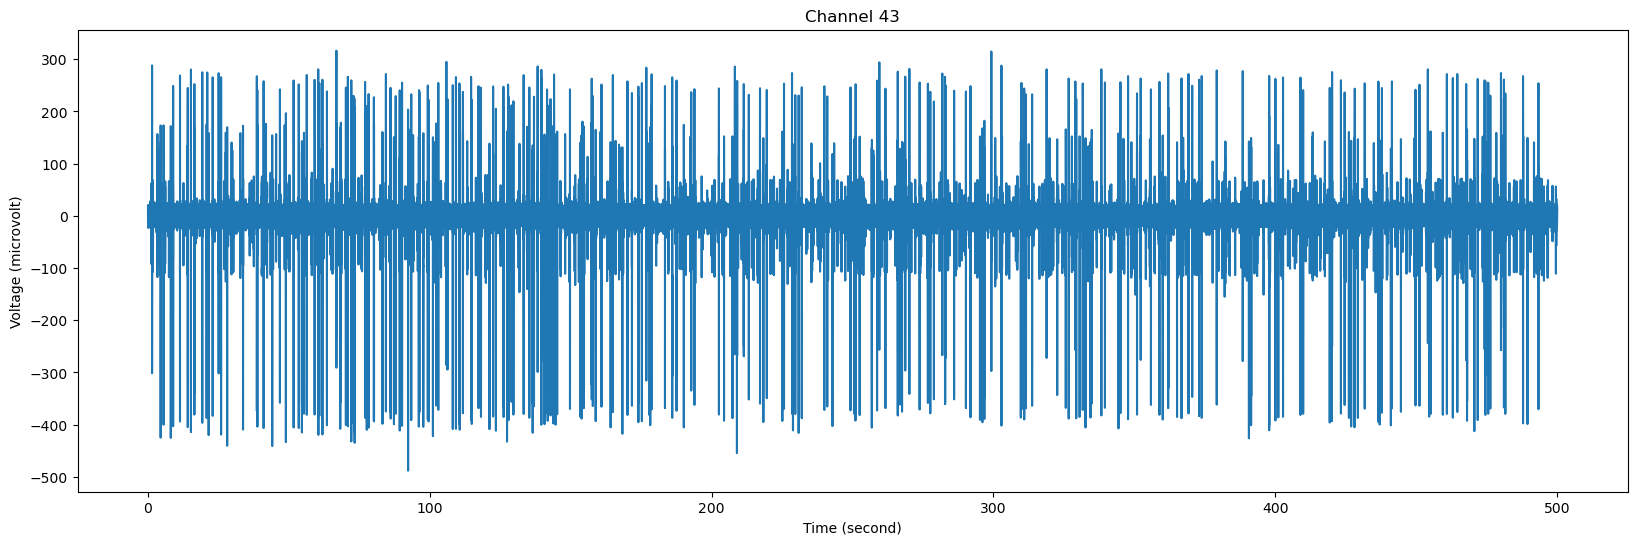

In [54]:
plot_analog_stream_channel(electrode_stream, 9, from_in_s=0, to_in_s=500)

In [8]:
channel_id = 171
info = electrode_stream.channel_infos[channel_id].info
print("Bandwidth: %s - %s Hz" % (info['HighPassFilterCutOffFrequency'], info['LowPassFilterCutOffFrequency']))

signal = electrode_stream.get_channel_in_range(channel_id, 0, electrode_stream.channel_data.shape[1])[0]

Bandwidth: 100 - 3500 Hz


## Threshold


In [9]:
noise_mad = np.median(np.absolute(signal)) / 0.6745

print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))

Noise Estimate by MAD Estimator     : 5.83227e-06 V


In [10]:
spike_threshold = -5 * noise_mad # roughly -30 µV

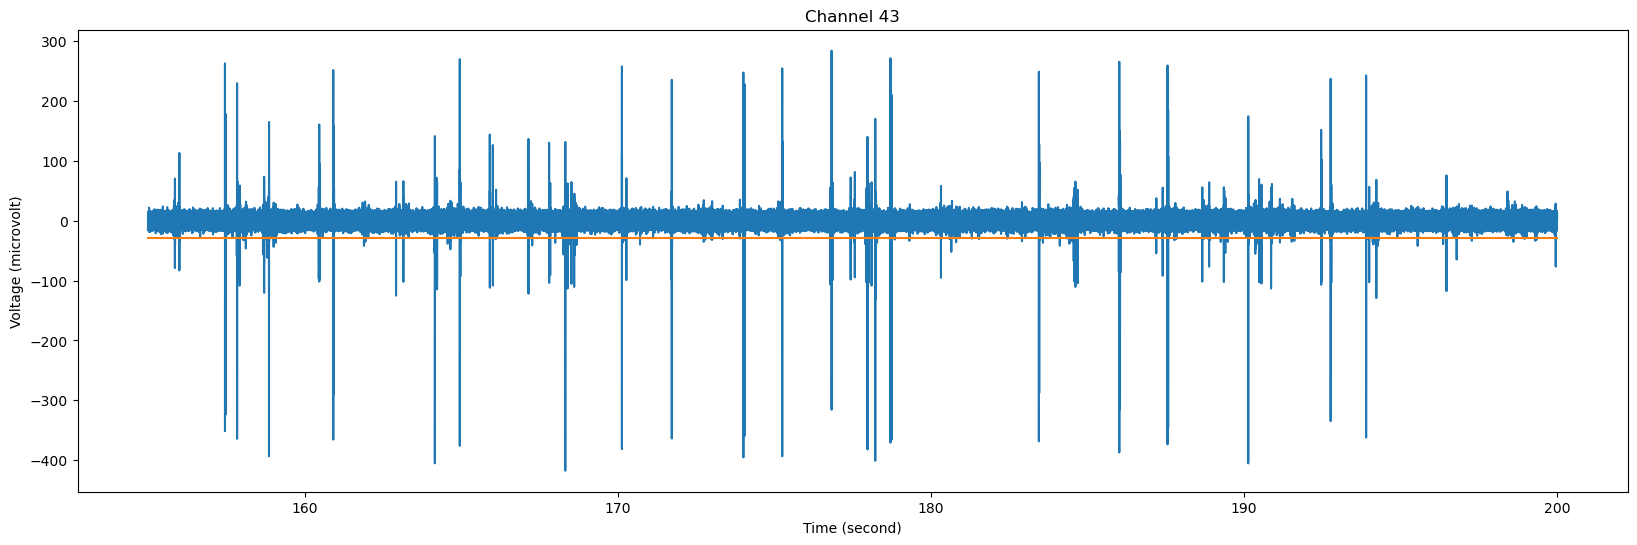

In [11]:
plot_analog_stream_channel(electrode_stream, 9, from_in_s=155, to_in_s=200, show=False)
_ = plt.plot([155, 200], [spike_threshold*1e6, spike_threshold*1e6]) # converts the threshold to µV for plotting
plt.show()

In [12]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
  
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]  #np.nonzero((signal > threshold).astype(int))[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings


In [13]:
def get_next_minimum(signal, index, max_samples_to_search):

    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

In [14]:
def align_to_minimum(signal, fs, threshold_crossings, search_range):

    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

## Spikes detection 

In [15]:
fs = int(electrode_stream.channel_infos[channel_id].sampling_frequency.magnitude)
crossings = detect_threshold_crossings(signal, fs, spike_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(signal, fs, crossings, 0.002) # search range 2 ms

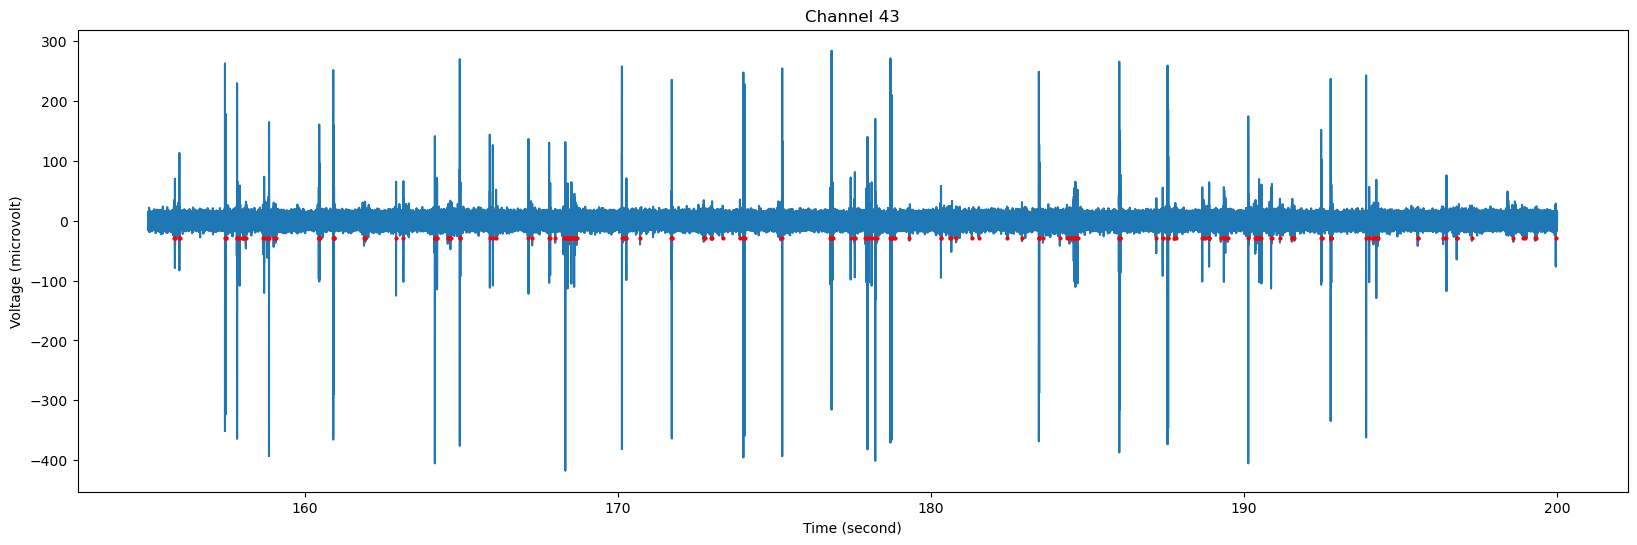

In [16]:
timestamps = spks / fs
range_in_s = (155, 200)
spikes_in_range = timestamps[(timestamps >= range_in_s[0]) & (timestamps <= range_in_s[1])]

plot_analog_stream_channel(electrode_stream, 9, from_in_s=range_in_s[0], to_in_s=range_in_s[1],show=False)
plt.plot(spikes_in_range, [spike_threshold*1e6]*spikes_in_range.shape[0], 'ro', ms=2)
plt.show()

## Spike Waveforms


In [17]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):

    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

In [18]:
pre = 0.001 # 1 ms
post= 0.002 # 2 ms
cutouts = extract_waveforms(signal, fs, spks, pre, post)
print(f'Cutout array shape:  {(cutouts.shape)}') # number of spikes x number of samples

Cutout array shape:  (2579, 75)


## Plot waveform

In [19]:
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):

    time_in_ms = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
         plt.figure(figsize=(12,6))
    
    for i in range(n):
         plt.plot(time_in_ms, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
         plt.xlabel('Time (%s)' % ureg.ms)
         plt.ylabel('Voltage (%s)' % ureg.uV)
         plt.title('Cutouts')
    
    if show:
        plt.show()

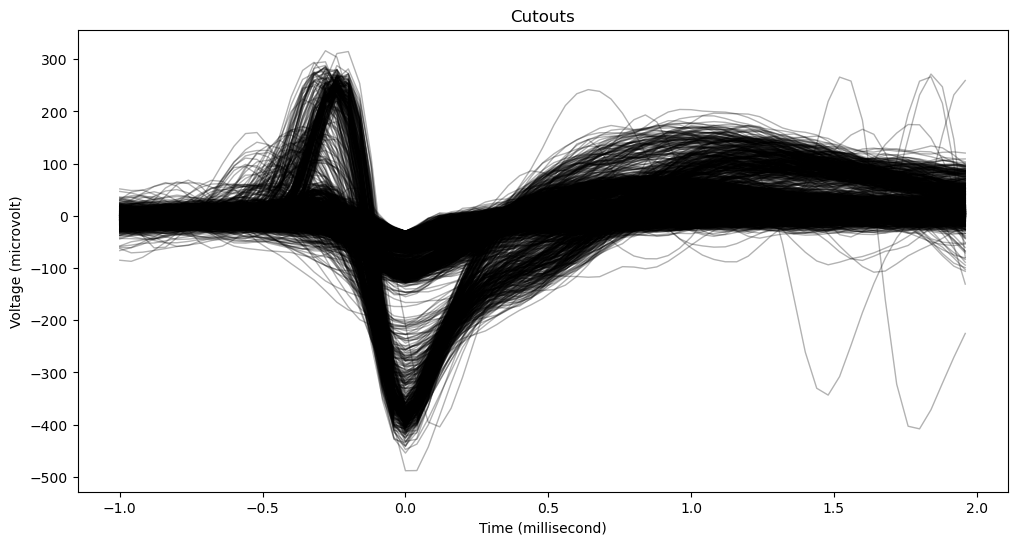

In [20]:
plot_waveforms(cutouts, fs, pre, post, n=cutouts.shape[0])

## Feature extracion

<Figure size 800x800 with 0 Axes>

Text(0.5, 0, 'Min. Amplitude (microvolt)')

Text(0, 0.5, 'Max. Amplitude (microvolt)')

Text(0.5, 1.0, 'Min/Max Spike Amplitudes')

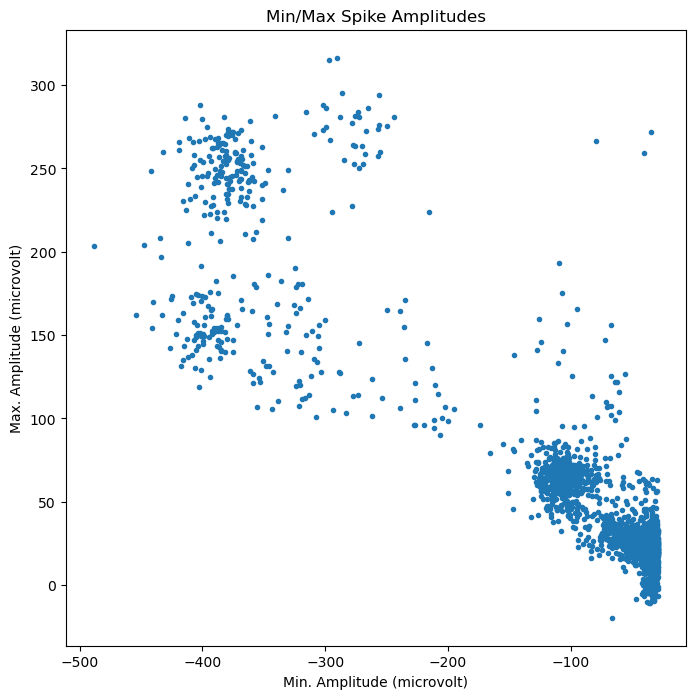

In [22]:
min_amplitude = np.amin(cutouts, axis=1)
max_amplitude = np.amax(cutouts, axis=1)

plt.figure(figsize=(8,8))
plt.plot(min_amplitude*1e6, max_amplitude*1e6,'.')
plt.xlabel('Min. Amplitude (%s)' % ureg.uV)
plt.ylabel('Max. Amplitude (%s)' % ureg.uV)
plt.title('Min/Max Spike Amplitudes')

plt.show()

## apply pca

In [23]:
scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(cutouts)

pca = PCA()
pca.fit(scaled_cutouts)
print(pca.explained_variance_ratio_)

PCA()

[4.95861981e-01 1.86792909e-01 1.07960458e-01 4.92467665e-02
 3.92615578e-02 2.43178104e-02 1.54772580e-02 1.42838769e-02
 1.32672412e-02 9.07951432e-03 6.22540386e-03 5.76332370e-03
 5.09706162e-03 4.57872079e-03 3.37948805e-03 2.88224864e-03
 2.35134998e-03 2.00488981e-03 1.77034798e-03 1.47102577e-03
 1.18203490e-03 1.06396539e-03 9.34307355e-04 7.84827463e-04
 7.03255677e-04 6.52196920e-04 5.41354290e-04 4.90419984e-04
 4.14199911e-04 3.63004816e-04 3.04959856e-04 2.61099008e-04
 2.01444988e-04 1.66950952e-04 1.47071914e-04 1.26653755e-04
 1.01048377e-04 8.93055456e-05 7.27223316e-05 6.06567333e-05
 4.77039212e-05 3.97085398e-05 3.42875628e-05 2.63952644e-05
 2.20130932e-05 1.76933484e-05 1.45767003e-05 1.18268421e-05
 9.58967283e-06 7.92411460e-06 6.38193314e-06 4.95505369e-06
 4.30927163e-06 3.46774565e-06 2.74747862e-06 2.31670474e-06
 1.79492225e-06 1.49837614e-06 1.21960289e-06 9.88322222e-07
 8.03217275e-07 6.44498157e-07 5.51653989e-07 3.94522000e-07
 3.29783060e-07 2.698258

## Plot PCA

<Figure size 800x800 with 0 Axes>

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'PC1 vs PC2')

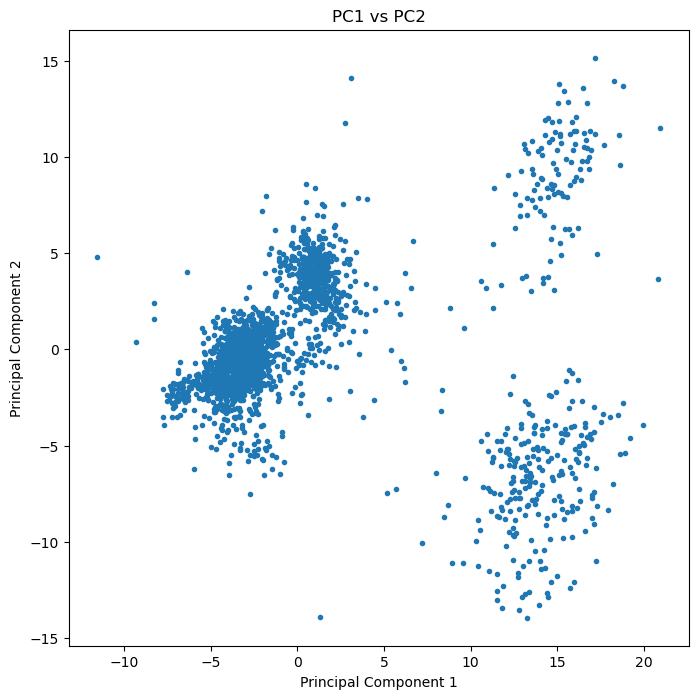

In [24]:
pca.n_components = 2
transformed = pca.fit_transform(scaled_cutouts)

plt.figure(figsize=(8,8))
plt.plot(transformed[:,0], transformed[:,1],'.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC1 vs PC2')

plt.show()

## clustering with gmm

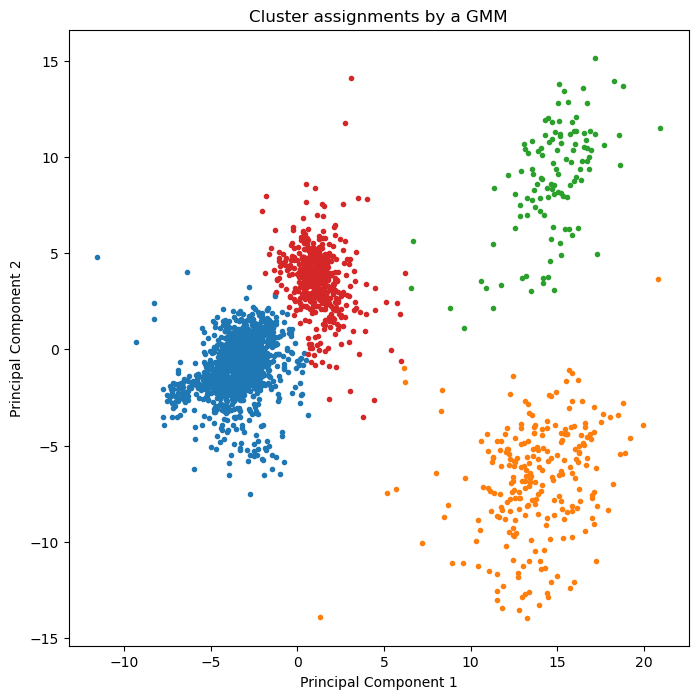

In [26]:
n_components = 4
gmm = GaussianMixture(n_components=n_components, n_init=10)
labels = gmm.fit_predict(transformed)

_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    _ = plt.plot(transformed[idx,0], transformed[idx,1],'.')
    _ = plt.title('Cluster assignments by a GMM')
    _ = plt.xlabel('Principal Component 1')
    _ = plt.ylabel('Principal Component 2')
    _ = plt.axis('tight')
plt.show()

## spike-plot

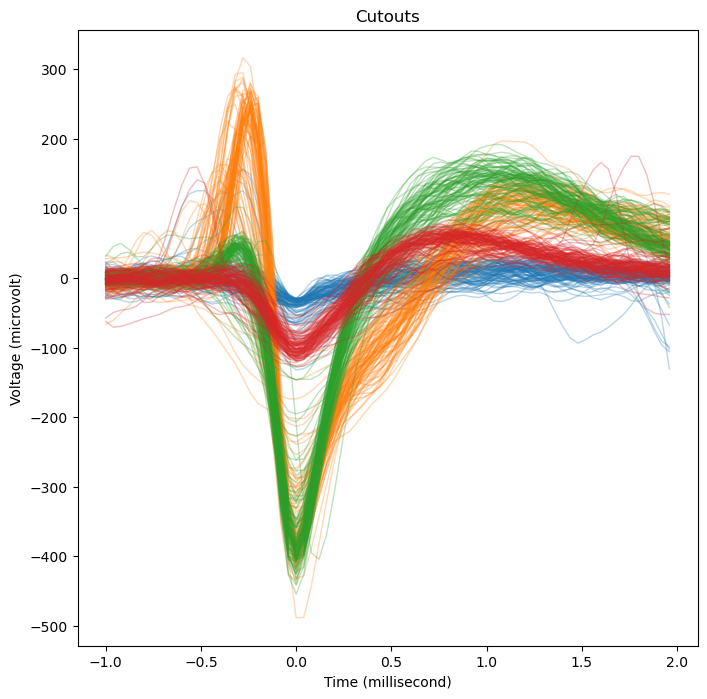

In [27]:
_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    plot_waveforms(cutouts[idx,:], fs, pre, post, n=100, color=color, show=False)
plt.show()

## spike train

In [35]:
spike_trains = {i: [] for i in range(4)}
for spike_time, cluster in zip(spks, labels):
    spike_trains[cluster].append(spike_time / fs)  # Convert to seconds

for cluster in spike_trains:
    spike_trains[cluster] = np.array(spike_trains[cluster])


for cluster, spikes in spike_trains.items():
    print(f"Cluster {cluster}: {spikes}")


Cluster 0: [  1.33444   1.48224   1.50108 ... 528.93736 528.94188 528.94692]
Cluster 1: [  1.45176   8.9272   11.36376  14.11924  15.2504   16.46388  16.47512
  19.26416  19.2752   21.03096  22.96012  22.97584  25.07592  25.9402
  38.62956  38.79316  38.826    41.03352  46.82576  46.8342   48.93592
  53.49844  54.65784  56.33912  59.13312  59.14208  60.40916  60.41612
  60.79736  61.89764  63.50724  63.52496  66.85728  66.86816  70.2284
  70.9318   72.13868  72.93996  72.95756  73.23896  73.33024  77.0322
  77.04368  77.05276  78.28572  80.16116  80.20328  84.43176  86.07076
  86.12624  87.90524  87.91696  89.3308   90.1514   92.29856  93.4156
  96.18704  96.28084  99.2928   99.30244  99.547   103.01488 105.8878
 105.89784 106.26908 108.15148 110.51264 110.62684 111.75676 114.66072
 114.89124 117.28916 117.29672 118.16184 122.46592 123.4594  126.12168
 126.19784 127.7744  127.93496 127.95348 129.01392 129.66916 133.30592
 135.31628 135.3268  136.97372 138.26452 138.27504 139.58152 139.

## plot spike train

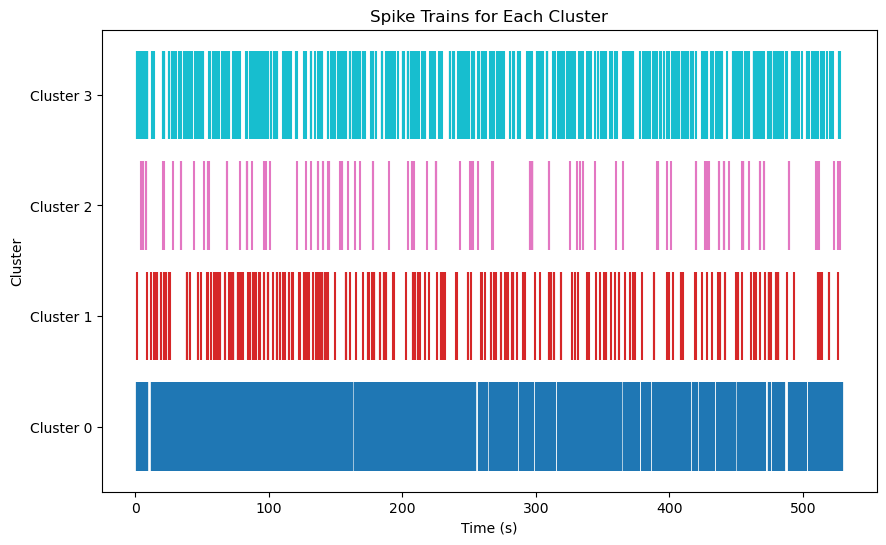

In [224]:
def plot_spike_trains(spike_trains, range_in_s=None):
    plt.figure(figsize=(10, 6))
    color_map = plt.cm.get_cmap('tab10', len(spike_trains))
    
    for cluster, spikes in spike_trains.items():
        # Filter spikes within the specified range if provided
        if range_in_s:
            spikes = spikes[(spikes >= range_in_s[0]) & (spikes <= range_in_s[1])]
        
        for spike in spikes:
            plt.vlines(spike, cluster - 0.4, cluster + 0.4, color=color_map(cluster))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Cluster')
    plt.title('Spike Trains for Each Cluster')
    plt.yticks(range(len(spike_trains)), [f'Cluster {i}' for i in spike_trains.keys()])
    plt.show()

plot_spike_trains(spike_trains)  # Example range, adjust as needed



## plot inter spike interval

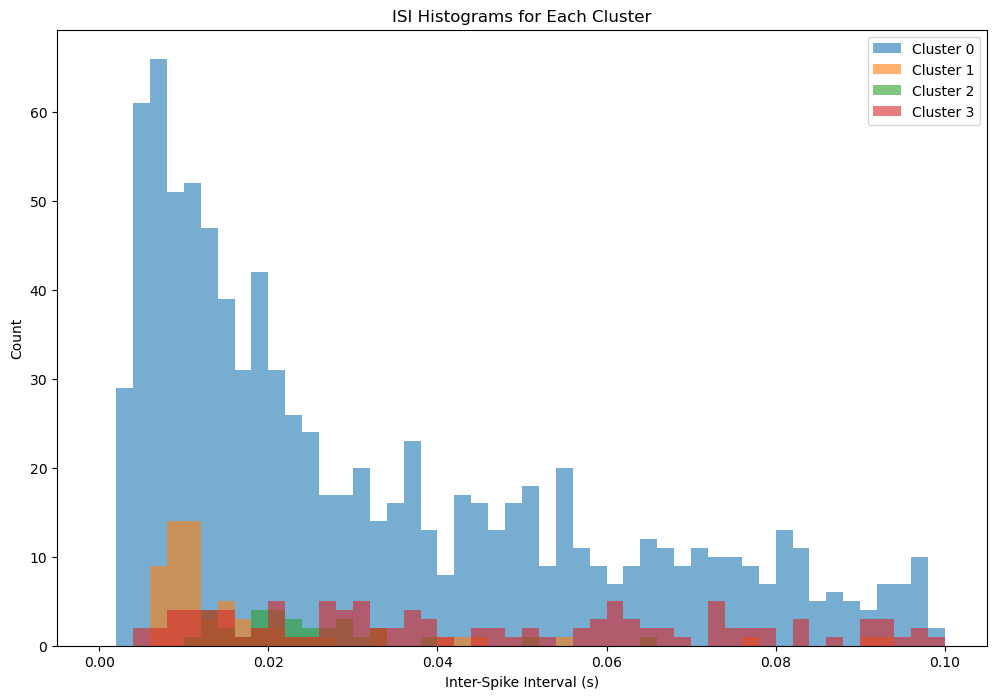

In [63]:
def calculate_isi(spike_times):
   
    return np.diff(np.sort(spike_times))

def plot_isi_histogram(spike_trains, bins=50, range=(0, 0.1)):
    
    plt.figure(figsize=(12, 8))
    
    for cluster, spikes in spike_trains.items():
        if len(spikes) > 1:  
            isi = calculate_isi(spikes)
            plt.hist(isi, bins=bins, range=range, alpha=0.6, label=f'Cluster {cluster}')
    
    plt.xlabel('Inter-Spike Interval (s)')
    plt.ylabel('Count')
    plt.title('ISI Histograms for Each Cluster')
    plt.legend()
    plt.show()





plot_isi_histogram(spike_trains)


## Fano factor and coefficient covarience

In [64]:
import numpy as np

def calculate_isi(spike_times):
    return np.diff(np.sort(spike_times))

def calculate_spike_counts(spike_times, window_size):
    max_time = np.max(spike_times)
    bins = np.arange(0, max_time + window_size, window_size)
    counts, _ = np.histogram(spike_times, bins=bins)
    return counts

def compute_cv_and_fano(spike_trains, window_size=1.0):
    cv_results = {}
    fano_results = {}
    
    for cluster, spikes in spike_trains.items():
        if len(spikes) > 1:  
            # Calculate ISI
            isi = calculate_isi(spikes)
            mean_isi = np.mean(isi)
            std_isi = np.std(isi)
            cv = std_isi / mean_isi if mean_isi > 0 else np.nan
            
            # Calculate spike counts in windows
            spike_counts = calculate_spike_counts(spikes, window_size)
            mean_count = np.mean(spike_counts)
            var_count = np.var(spike_counts)
            fano = var_count / mean_count if mean_count > 0 else np.nan
            
            cv_results[cluster] = cv
            fano_results[cluster] = fano
        else:
            cv_results[cluster] = np.nan
            fano_results[cluster] = np.nan
    
    return cv_results, fano_results

# Compute CV and Fano Factor
cv_results, fano_results = compute_cv_and_fano(spike_trains, window_size=1.0)

# Display results
print("Coefficient of Variation (CV) for each cluster:")
for cluster, cv in cv_results.items():
    print(f"Cluster {cluster}: {cv:.4f}")

print("\nFano Factor for each cluster:")
for cluster, fano in fano_results.items():
    print(f"Cluster {cluster}: {fano:.4f}")


Coefficient of Variation (CV) for each cluster:
Cluster 0: 1.4705
Cluster 1: 1.1733
Cluster 2: 1.3008
Cluster 3: 1.1108

Fano Factor for each cluster:
Cluster 0: 2.4179
Cluster 1: 1.3866
Cluster 2: 1.8665
Cluster 3: 1.2752


## Evaluation

In [38]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(transformed, labels)
print(f'Silhouette Score: {sil_score:.2f}')


spike_trains = {i: [] for i in range(n_components)}
for spike_time, cluster in zip(spks, labels):
    spike_trains[cluster].append(spike_time / fs)  # Convert to seconds

for cluster in spike_trains:
    spike_trains[cluster] = np.array(spike_trains[cluster])


for cluster, spikes in spike_trains.items():
    print(f"Cluster {cluster}: {spikes}")

Silhouette Score: 0.66
Cluster 0: [  1.33444   1.48224   1.50108 ... 528.93736 528.94188 528.94692]
Cluster 1: [  1.45176   8.9272   11.36376  14.11924  15.2504   16.46388  16.47512
  19.26416  19.2752   21.03096  22.96012  22.97584  25.07592  25.9402
  38.62956  38.79316  38.826    41.03352  46.82576  46.8342   48.93592
  53.49844  54.65784  56.33912  59.13312  59.14208  60.40916  60.41612
  60.79736  61.89764  63.50724  63.52496  66.85728  66.86816  70.2284
  70.9318   72.13868  72.93996  72.95756  73.23896  73.33024  77.0322
  77.04368  77.05276  78.28572  80.16116  80.20328  84.43176  86.07076
  86.12624  87.90524  87.91696  89.3308   90.1514   92.29856  93.4156
  96.18704  96.28084  99.2928   99.30244  99.547   103.01488 105.8878
 105.89784 106.26908 108.15148 110.51264 110.62684 111.75676 114.66072
 114.89124 117.28916 117.29672 118.16184 122.46592 123.4594  126.12168
 126.19784 127.7744  127.93496 127.95348 129.01392 129.66916 133.30592
 135.31628 135.3268  136.97372 138.26452 1

## Inter spike interval

## Firing rate plot

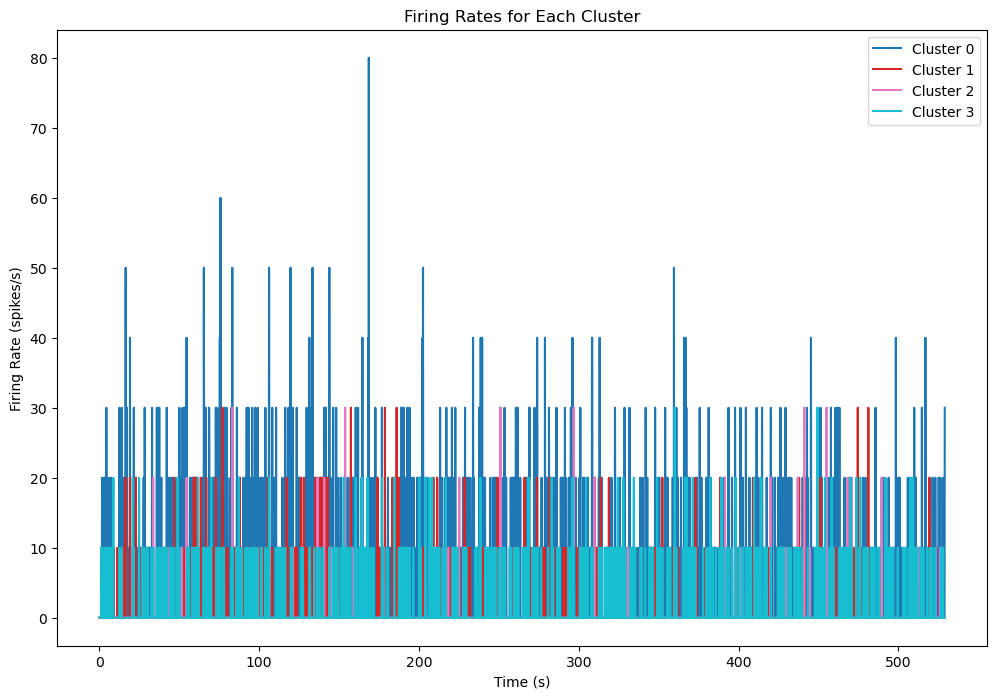

In [61]:
def calculate_firing_rate(spike_times, bin_width, total_time):
    
    bins = np.arange(0, total_time + bin_width, bin_width)
    spike_counts, _ = np.histogram(spike_times, bins=bins)
    firing_rate = spike_counts / bin_width
    bin_centers = bins[:-1] + bin_width / 2
    return bin_centers, firing_rate

def plot_firing_rates(spike_trains, bin_width, total_time):
    
    plt.figure(figsize=(12, 8))
    color_map = plt.cm.get_cmap('tab10', len(spike_trains))
    
    for cluster, spikes in spike_trains.items():
        if len(spikes) > 0:  # Ensure there are spikes to plot
            bin_centers, firing_rate = calculate_firing_rate(spikes, bin_width, total_time)
            plt.plot(bin_centers, firing_rate, label=f'Cluster {cluster}', color=color_map(cluster))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (spikes/s)')
    plt.title('Firing Rates for Each Cluster')
    plt.legend()
    plt.show()


# Define bin width and total recording time
bin_width = 0.1  # in seconds
total_time = np.max([np.max(spikes) for spikes in spike_trains.values()])

# Plot firing rates
plot_firing_rates(spike_trains, bin_width, total_time)


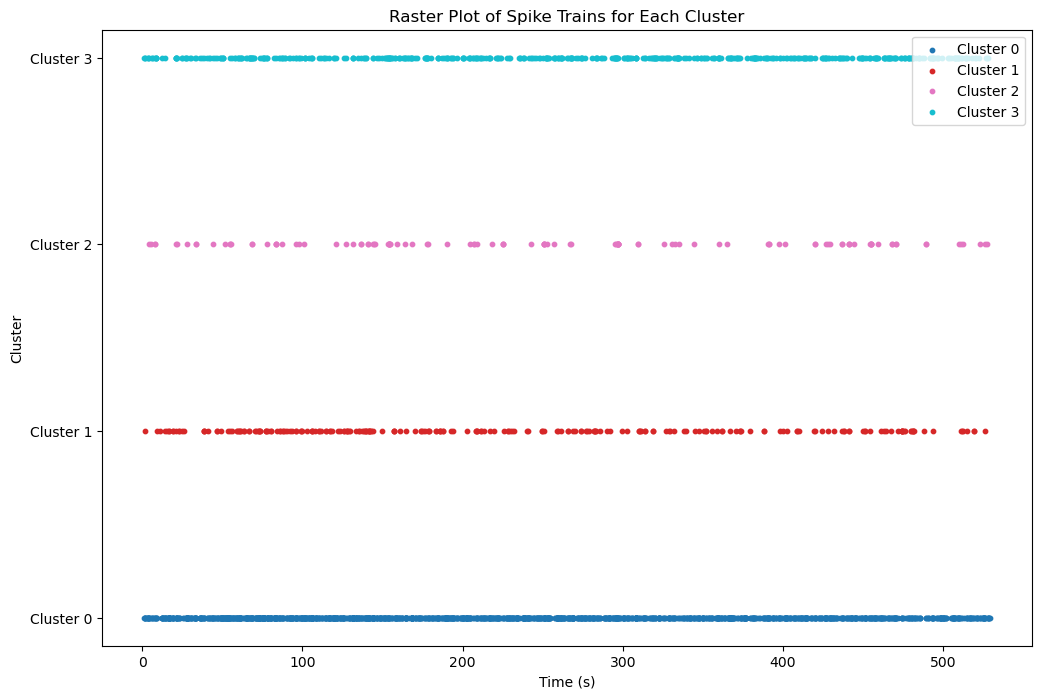

In [60]:
def plot_raster(spike_trains, range_in_s=None):
    plt.figure(figsize=(12, 8))
    color_map = plt.cm.get_cmap('tab10', len(spike_trains))
    
    for cluster, spikes in spike_trains.items():
        # Filter spikes within the specified range if provided
        if range_in_s:
            spikes = spikes[(spikes >= range_in_s[0]) & (spikes <= range_in_s[1])]
        
        # Plot each spike as a dot
        plt.scatter(spikes, np.full_like(spikes, cluster), color=color_map(cluster), s=10, label=f'Cluster {cluster}')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Cluster')
    plt.title('Raster Plot of Spike Trains for Each Cluster')
    plt.yticks(range(len(spike_trains)), [f'Cluster {i}' for i in spike_trains.keys()])
    plt.legend(loc='upper right')
    plt.show()



# Plot the raster plot
plot_raster(spike_trains)
